In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets import interact
from scipy import signal
from collections import deque

In [2]:
class LiveFilter:
    def __init__(self, b, a):
        '''
        Args:
            b (array-like): numerator coefficients from scipy
            a (array-like): denominator coefficients from scipy
        '''
        
        self.b = b
        self.a = a
        self._xs = deque([0] * len(b), maxlen=len(b))
        self._ys = deque([0] * (len(a) - 1), maxlen=len(a) - 1)
    
    def process(self, x):
        if np.isnan(x):
            return x
        return self._process(x)
    
    def __call__(self, x):
        return self.process(x)
    
    def _process(self, x):
        self._xs.appendleft(x)
        y = np.dot(self.b, self._xs) - np.dot(self.a[1:], self._ys)
        y /= self.a[0]
        self._ys.appendleft(y)
        
        return y

In [3]:
np.random.seed(42)
fs = 30 # Sampling rate Hz
ts = np.arange(0, 5, 1.0 / fs) # 5 seconds

ys = np.sin(2*np.pi * 1.0 * ts) # 1.0 Hz signal
yerr = 0.5 * np.random.normal(size=len(ts)) # Gaussian noise
yraw = ys + yerr

In [4]:
# Low pass filter with 2.5 Hz cutoff
b, a = signal.iirfilter(4, Wn=2.5, fs=fs, btype='low', ftype='butter')

y_scipy_lpf = signal.lfilter(b, a, yraw)

live_lpf = LiveFilter(b, a)
y_live_lpf = [live_lpf(y) for y in yraw]

Text(0, 0.5, 'Amplitude')

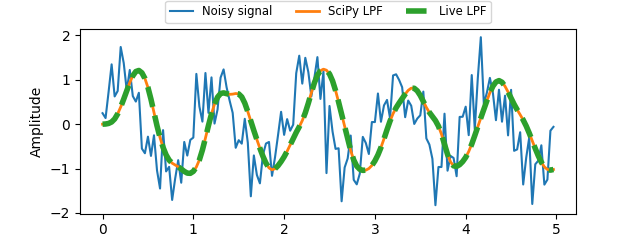

In [5]:
plt.figure(figsize=(6.4, 2.4))
plt.plot(ts, yraw, label='Noisy signal')
plt.plot(ts, y_scipy_lpf, lw=2, label='SciPy LPF')
plt.plot(ts, y_live_lpf, lw=4, ls='dashed', label='Live LPF')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize='smaller')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

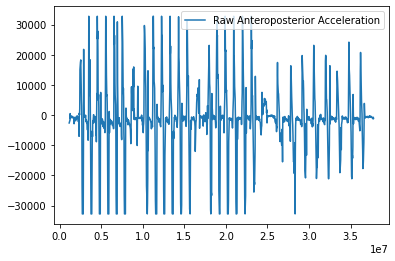

In [7]:
%matplotlib inline

# Real IMU data
data_str = []
with open('raw.txt', 'r') as f:
    data_str = [line.rstrip('\n').split(',') for line in f.readlines()]

data_split = list(zip(*data_str))

ts = np.array(list(map(int, data_split[0])))
y_raw = np.array(list(map(float, data_split[1])))
plt.plot(ts, y_raw, label='Raw Anteroposterior Acceleration')
plt.legend()

In [8]:
# Determine average sampling rate
freq = 0
for i in range(len(ts[:-1])):
    freq += abs(ts[i + 1] - ts[i])

freq /= len(ts[:-1]) * 1.0e6 # Seconds per sample
freq = 1./freq
freq

29.809621983118028

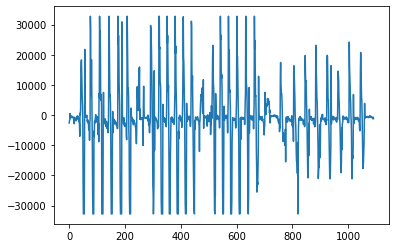

In [9]:
%matplotlib inline

# Find a slice to analyze
plt.plot(range(len(y_raw)), y_raw)

300


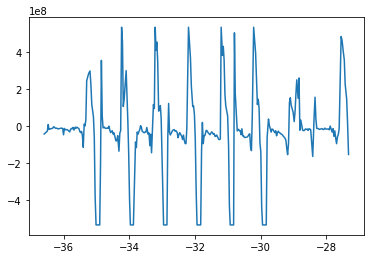

In [17]:
%matplotlib inline
# 2510, 2600 for window 2400, 2800 for 5 steps
sl_start = 0
sl_end = 300
sl = slice(sl_start, sl_end) # 1200, 3100
ts_slice = (ts[sl] - ts[sl_start - 1] )/ 1.0e6
y_raw_slice = y_raw[sl] * 16384
print(len(y_raw_slice))
plt.plot(ts_slice, y_raw_slice)
#print(list(y_raw_slice))

[9.500782500624535e-05, 0.0003800313000249814, 0.0005700469500374721, 0.0003800313000249814, 9.500782500624535e-05] [1.0, -3.449698968749918, 4.495498752290128, -2.620084297093263, 0.5758046387531529]


interactive(children=(IntSlider(value=153, description='val', max=300, min=6), Output()), _dom_classes=('widge…

<function __main__.update(val)>

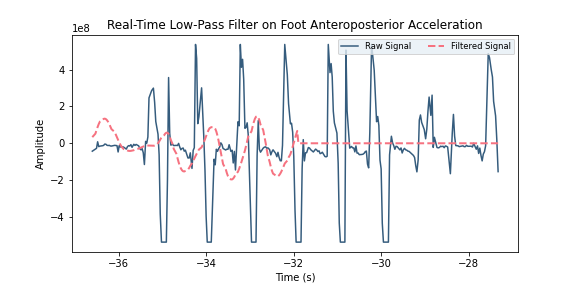

In [34]:
%matplotlib widget

# Low pass filter with 2 Hz cutoff
b, a = signal.iirfilter(4, Wn=1, fs=freq, btype='low', ftype='butter')

print(list(b), list(a))

live_lpf = LiveFilter(b, a)

y_live_lpf = [live_lpf(y) for i, y in enumerate(y_raw_slice)]
#int(list(y_live_lpf))

slope = [0] * len(y_live_lpf)

fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(ts_slice, y_raw_slice, label='Raw Signal', color='#355C7D')
#plt.plot(ts_slice, y_scipy_lpf, lw=2, label='SciPy LPF')
live, = ax.plot(ts_slice, y_live_lpf, lw=2, ls='dashed', color='#F67280', label='Filtered Signal')
#ax.set_ylim(-2.5, 2.5)
ax.set_facecolor('white')
#grad, = ax.plot(ts_slice, slope, lw=2, ls='dashed', label='Gradient')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=3, fontsize='smaller', facecolor='#E7EFF5')
plt.title('Real-Time Low-Pass Filter on Foot Anteroposterior Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

def update(val):
    y_live_lpf = [live_lpf(y) for y in y_raw_slice]
    y_live_lpf[val:] = [0] * len(y_live_lpf[val:])
    live.set_ydata(y_live_lpf)
    slope = np.gradient(y_live_lpf)
    #grad.set_ydata(slope)
    fig.canvas.draw_idle()

fig.savefig('lpf_sample.png', facecolor=fig.get_facecolor(), transparent=True)
interact(update, val=(6, len(y_raw_slice), 1))

[0.00263406 0.01053625 0.01580437 0.01053625 0.00263406] [ 1.         -2.63001353  2.75386911 -1.32926778  0.2475572 ]


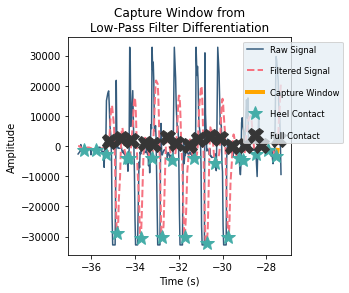

In [21]:
%matplotlib inline
# Low pass filter with 2 Hz cutoff
b, a = signal.iirfilter(4, Wn=2.5, fs=freq, btype='low', ftype='butter')

print(b, a)

live_lpf = LiveFilter(b, a)

y_live_lpf = [live_lpf(y) for i, y in enumerate(y_raw)]

# Find contact points
contact_ts = []
contact_ys = []
prev_diff = 0

contact_index = 0

for i in range(len(y_live_lpf[sl][:-1])):
    diff = y_live_lpf[sl][i+1] - y_live_lpf[sl][i]
    if diff >= 0 and prev_diff < 0:
        contact_ts.append(ts_slice[i])
        contact_ys.append(y_live_lpf[sl][i])
        contact_index = i
    prev_diff = diff
    
# Find raise point
raise_ts = []
raise_ys = []
raise_index = 0

for i in range(len(y_live_lpf[sl][1:])):
    if y_live_lpf[sl][i] >= 0 and y_live_lpf[sl][i-1] < 0:
        raise_ts.append(ts_slice[i])
        raise_ys.append(y_live_lpf[sl][i])
        raise_index = i


# Plot figure
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.plot(ts_slice, y_raw[sl], label='Raw Signal', color='#355C7D')
#plt.plot(ts_slice, y_scipy_lpf, lw=2, label='SciPy LPF')
ax.plot(ts_slice, y_live_lpf[sl], lw=2, ls='dashed', color='#F67280', label='Filtered Signal')
ax.plot(ts_slice[contact_index:raise_index], y_live_lpf[sl][contact_index:raise_index], lw=4, label='Capture Window', color='#ffa600')
ax.plot(contact_ts, contact_ys, '*', ms=15, color='#45ADA8', label='Heel Contact')
ax.plot(raise_ts, raise_ys, 'X', ms=15, color='#363636', label='Full Contact')

#ax.set_ylim(-2.5, 2.5)
ax.set_facecolor('white')
#grad, = ax.plot(ts_slice, slope, lw=2, ls='dashed', label='Gradient')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='smaller', facecolor='#E7EFF5', labelspacing=1.5)
#plt.plot([2], [1], 'o')
plt.title('Capture Window from\nLow-Pass Filter Differentiation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

fig.savefig('lpf_window_sample.png', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (300,) and (400,)

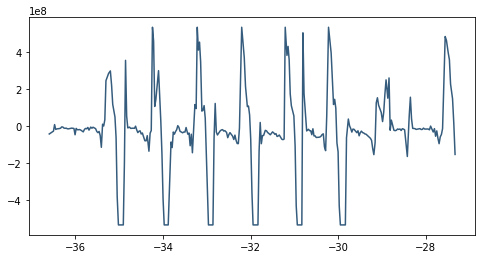

In [22]:
data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10211, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -13299, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -12301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -13186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(ts_slice, y_raw_slice, label='Raw Signal', color='#355C7D')
ax.plot(ts_slice, data, '.', color='#F67280', label='C Filtered Signal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=3, fontsize='smaller', facecolor='#E7EFF5')
plt.title('Real-Time Low-Pass Filter on Foot Anteroposterior Acceleration (in C)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')